In [1]:
import matplotlib.image as mpimg
#Importing some modules 

import os 
from datetime import datetime
from datetime import date

%matplotlib inline

%load_ext autoreload
%autoreload
import matplotlib as mpl
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import pandas as pd
from numba import jit

import more_itertools as mit
from statsmodels.stats.multitest import fdrcorrection
from heapq import nsmallest
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d
from os import walk
from ast import literal_eval
import re 
import scipy
from scipy.ndimage import gaussian_filter
import more_itertools as mit
import random
from datetime import date

from scipy import stats
from PIL import Image

import seaborn as sns

import xml.etree.ElementTree as ET



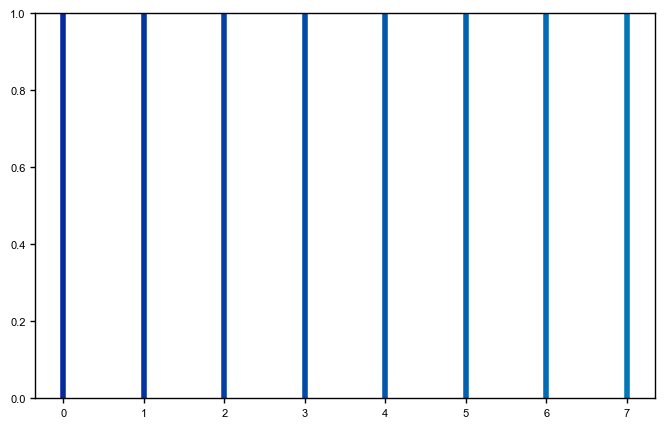

In [4]:
#GENERAL FUNCTIONS 
def generate_folder_path(dirs):
    for i in dirs:
        try:
            os.makedirs(i)
            print("Directory " , i ,  " Created ")
        except FileExistsError:
            print("Directory " , i ,  " already exists")  
            
def load_stim_file(dp_StimF): 
    os.chdir(dp_StimF)
    StimFs = []
    StimFs.append(genfromtxt('StimF1.txt', delimiter=',').astype(int))
    return StimFs[0]
def load_stim_file_multiple(dp_StimF, num): 
    os.chdir(dp_StimF)
    StimFs = []
    StimFs.append(genfromtxt('StimF{}.txt'.format(num), delimiter=',').astype(int))
    return StimFs[0]

def load_s2p_files(dp_s2p, neuropil_correction):
    """ this function loads the suite2p output files 
    #can refine this to load only a subset of files 
    https://mouseland.github.io/suite2p/_build/html/outputs.html 
    Parameters: s2p datapath, neuropil correction value (if 0, do no correction) 
    Returns:F, Spks, ops,iscell,stat,Fneu """ 
    
    os.chdir(dp_s2p)
    F = np.load('F.npy')
    Spks = np.load('Spks.npy')
    ops = np.load('ops.npy', allow_pickle=True).item() #from the suite2p github 
    iscell = np.load('iscell.npy') #first col is binary yes or no and second col is prob. classifier that is cell 
    stat = np.load('stat.npy', allow_pickle=True)
    Fneu = np.load('Fneu.npy')

    if neuropil_correction > 0: 
        F = F-Fneu*neuropil_correction
        for idx,i in enumerate(F): 
            F[idx] = i-np.min(i)
    return F, Spks, ops,iscell,stat,Fneu

def pre_process_imaging(iscell, F, stat, FOVsizeum, mode):
    """ 'Gives you dff for cells of interest and stim triggers 
    Paramters: iscell, F, stat, FOVsizeum, dp_StimF, mode (median or 10% median dff)
    Returns: FNc, iscell_list, x,y, StimFs
    
    '"""
    iscell_list = get_curated_cells(iscell)
    Fc = F[iscell_list] 
    if mode == 'median':
        FNc = dff_median(Fc)
    elif mode == '10': 
        FNc = dff_10percent(Fc)
    x, y = get_cell_centroids(stat, iscell_list)
    xa = [i*(FOVsizeum/512) for i in x]
    yb = [i*(FOVsizeum/512) for i in y]
    return FNc, iscell_list, xa,yb, x,y

def get_cell_centroids(stat, index_list):
    #this function finds the x and y centroids from the stat file from suite2p 
    x,y = zip(*[(stat[i]['med'][1], stat[i]['med'][0]) for i in index_list])
    return x,y

def get_curated_cells(iscell): 
    return np.where(iscell[:,0] == 1)[0]

def dff_10percent(traces): 
    a = np.empty_like(traces) 
    k = int(len(traces[0])/10)
    for idx,i in enumerate(traces): 
        bsl = np.median(i[np.argpartition(i, k)[:k]])
        a[idx] = (i-bsl)/bsl
    return a
def dff_median(traces): 
    a = np.empty_like(traces) 
    k = int(len(traces[0])/10)
    for idx,i in enumerate(traces): 
        bsl = np.median(i)#[np.argpartition(i, k)[:k]])
        a[idx] = (i-bsl)/bsl
    return a

def grab_file_info(dp): 
    """ This function gets the relevant information of a file from the name 
        
        Parameters: datapath 

        Returns: Mouse_ID, Date

    """ 
    f = []
    for (dirpath, dirnames, filenames) in walk(dp):
        f.extend(filenames)
        break
    Mouse_ID = f[0].split('.')[0][6:9]
    Date = f[0].split('.')[0][:6]
    return Mouse_ID, Date
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def behaviour_trial_function_1Map(data, start_trial):
    
    behav_trial_lengths = [len(i) for i in data[start_trial:]]
    behav_trials = []
    for i in data[start_trial:]: 
        this_trial = i
        this_trial_list = []
        for u in this_trial: 
            this_trial_list.append(u[0])
        behav_trials.append(this_trial_list)
        
    return behav_trial_lengths, behav_trials

def get_imaging_trial_lengths(Triggers):
    
    img_trial_lengths = []
    for idx, i in enumerate(Triggers[:-1]):
        img_trial_lengths.append(Triggers[idx+1] - Triggers[idx])
        
    return img_trial_lengths

def re_sample_behaviour(behav_trials, img_trial_lengths, y_start, y_end): 
    re_sampled_behav = []
    for idx, i in enumerate(behav_trials): 
        re_sample = scipy.signal.resample(i, img_trial_lengths[idx])
        re_sample[re_sample < y_start] = y_start
        re_sample[re_sample > y_end] = y_end
        re_sample[0:10], re_sample[-10:] = y_start, y_end
        re_sampled_behav.append(re_sample)
    return re_sampled_behav

def re_sample_speed(behav_trials, img_trial_lengths): 
    re_sampled_behav = []
    for idx, i in enumerate(behav_trials): 
        re_sample = scipy.signal.resample(i, img_trial_lengths[idx])
#         re_sample[re_sample < y_start] = y_start
#         re_sample[re_sample > y_end] = y_end
#         re_sample[0:10], re_sample[-10:] = y_start, y_end
        re_sampled_behav.append(re_sample)
    return re_sampled_behav

def normalizedata(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

@jit(nopython=True)
def interpolation(arr_3d,):
    result=np.zeros_like(arr_3d)
    for i in range(arr_3d.shape[0]):
        for j in range(arr_3d.shape[1]):
            arr=arr_3d[i,j,:]
            # If all elements are nan then cannot conduct linear interpolation.
            if np.sum(np.isnan(arr))==arr.shape[0]:
                result[i,j,:]=arr
            else:
                # If the first elemet is nan, then assign the value of its right nearest neighbor to it.
                if np.isnan(arr[0]):
                    arr[0]=arr[~np.isnan(arr)][0]
                # If the last element is nan, then assign the value of its left nearest neighbor to it.
                if np.isnan(arr[-1]):
                    arr[-1]=arr[~np.isnan(arr)][-1]
                # If the element is in the middle and its value is nan, do linear interpolation using neighbor values.
                for k in range(arr.shape[0]):
                    if np.isnan(arr[k]):
                        x=k
                        x1=x-1
                        x2=x+1
                        # Find left neighbor whose value is not nan.
                        while x1>=0:
                            if np.isnan(arr[x1]):
                                x1=x1-1
                            else:
                                y1=arr[x1]
                                break
                        # Find right neighbor whose value is not nan.
                        while x2<arr.shape[0]:
                            if np.isnan(arr[x2]):
                                x2=x2+1
                            else:
                                y2=arr[x2]
                                break
                        # Calculate the slope and intercept determined by the left and right neighbors.
                        slope=(y2-y1)/(x2-x1)
                        intercept=y1-slope*x1
                        # Linear interpolation and assignment.
                        y=slope*x+intercept
                        arr[x]=y
                result[i,j,:]=arr
    return result

def behaviour_pre_processing(dp_behav, StimFs, y_start, y_end): 
    os.chdir(dp_behav)
    Mouse_ID, Date = grab_file_info(dp_behav)
    behaviour_data = fully_sorted_data(dp_behav, Date)    
    behav_trial_lengths, behav_trials = behaviour_trial_function_1Map(behaviour_data, 1)
    img_trial_lengths = get_imaging_trial_lengths(StimFs)
    re_sampled_behav = re_sample_behaviour(behav_trials, img_trial_lengths, y_start, y_end)

    behav_speed = []
    for t in behav_trials:
        speed_list = []
        for i in range(20,len(t)):
            speed_list.append((np.max(t[i-20:i])-np.min(t[i-20:i]))*0.5/(20/55))
        speed_list = [speed_list[0]]*20 + speed_list
        behav_speed.append(speed_list)
    re_sampled_speed = re_sample_speed(behav_speed, img_trial_lengths)


    return re_sampled_behav, re_sampled_speed, behav_trial_lengths

def fully_sorted_data(dp_behav, Date):
    os.chdir(dp_behav)
    file_names = [i for i in os.listdir(dp_behav) if os.path.isfile(os.path.join(dp_behav,i)) and Date in i[:6]]
    file_names2 = []
    for x in sorted_nicely(file_names):
        file_names2.append(x)
    data  = []
    for i in file_names2:
        with open(i, 'r') as f:
            this_data = literal_eval('[' + ''.join(f.readlines()) + ']')
        data.append(this_data[0])
    return data 


#PLACE CELL FUNCTIONS 

def new_rate_map(traces, speed, y_start, y_end, binsize, triggers, trial_n, re_sampled_behav):
    tracesc = np.array(traces, copy=True)  
    bins = np.arange(y_start, y_end+binsize, binsize)
    master = np.zeros([len(trial_n), len(tracesc), len(bins)] )
    for tdx, t in enumerate(trial_n): 
        bt = re_sampled_behav[t]
        st = speed[t]
        tt = tracesc[:,triggers[t]:triggers[t+1]]
        dig = np.digitize(bt,bins)
        tt[:, np.where(st < 5)[0]] = np.nan
        master[tdx] = np.array([tt[:,dig == i].mean(axis=1) for i in range(0,len(bins))]).transpose()
    return interpolation(master)

def new_rate_map_shuffle(traces, speed, y_start, y_end, binsize, triggers, trial_n, re_sampled_behav):
    tracesc = np.array(traces, copy=True)  
    bins = np.arange(y_start, y_end+binsize, binsize)
    master = np.zeros([len(trial_n), len(tracesc), len(bins)] )
    for tdx, t in enumerate(trial_n): 
        bt = re_sampled_behav[t]
        st = speed[t]
        tt = np.roll(tracesc[:,triggers[t]:triggers[t+1]], random.randint(5*30, 100000))
        dig = np.digitize(bt,bins)
        tt[:, np.where(st < 5)[0]] = np.nan
        master[tdx] = np.array([tt[:,dig == i].mean(axis=1) for i in range(0,len(bins))]).transpose()
    return interpolation(master)

def peaksort(alist):
    return np.argmax(alist)

def place_cell_dombeck(trace):
    #trace = gaussian_filter(Map1_mean_traces[221],sigma = 3)
    max_bins = 80
    min_bins = 4
    df_thresh = 0.1

#     trace = trace-np.min(trace)
    peak = np.max(trace)
    minn = np.median(sorted(trace)[:int(len(trace)/4)])
    greater_indicies = [udx for udx, u in enumerate(trace) if u > (peak-minn)/4]
    fields = [list(group) for group in mit.consecutive_groups(greater_indicies)]
    big_enough_fields = [i for i in fields if max_bins >len(i) > min_bins]
    percent_20 = []
    for i in big_enough_fields: 
        if len([c for c in [trace[u] for u in i] if c > df_thresh]) > 1: 
            percent_20.append(i)
    thresholded_field = []
    for i in percent_20: 
        if np.mean([trace[u] for u in i]) > np.mean([c for cdx, c in enumerate(trace) if cdx not in i])*3: 
            thresholded_field.append(i)
    return thresholded_field

def calculate_map_stability(rate_map): 
    corr = []
    for idx, i in enumerate(rate_map): 
        remaing = rate_map[(np.arange(rate_map.shape[0]) != idx),:]
        corr.append(np.corrcoef(i, np.mean(remaing,axis=0))[1,0])
    return np.mean(corr)

def my_z_score(dist, value):
    mean = np.mean(dist)
    std = np.std(dist)
    return (value-mean)/std

def my_place_cell_func(smoothed_trace, shuffled_peaks): 
    return my_z_score(shuffled_peaks,np.max(smoothed_trace))


def calculate_map_stability(rate_map, Sigma): 
    corr = []
    for idx, i in enumerate(rate_map): 
        remaing = rate_map[(np.arange(rate_map.shape[0]) != idx),:]
        corr.append(np.corrcoef(gaussian_filter(i,sigma = Sigma), gaussian_filter(np.mean(remaing,axis=0),sigma = Sigma))[1,0])
    return corr

def FWHM(X,Y):
    half_max = max(Y) / 2
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(Y[0:-1])) - np.sign(half_max - np.array(Y[1:]))
    #plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return left_idx,right_idx # X[right_idx], X[left_idx] #return the difference (full width)

def PC_FWHM_field_width(trace):
    bsl = np.median(sorted(trace)[:int(len(trace)/5)]) #median of 20% lowest values
    trace = trace - bsl
    r_trace = trace[::-1]
    try: 
        r = np.argmax(trace) + next(xdx for xdx, x in enumerate(trace[np.argmax(trace):]) if x < np.max(trace)/2)
    except: r = 200
    try:
        l = np.argmax(trace) - next(xdx for xdx, x in enumerate(r_trace[np.argmax(r_trace):]) if x < np.max(trace)/2)
    except: l = 0
    return r-l

#NEW FUNCTIONS 
def flatten_list(l): 
    return [item for sublist in l for item in sublist]


def new_rate_map(behav_trials, behav_speed, img_vector_trial_blocked, binsize, track_length):
    bins = np.arange(0, track_length+binsize, binsize)
    master = np.zeros([len(behaviour_data), img_vector_trial_blocked[0].shape[0], len(bins)] )
    for tdx, t in enumerate(behav_trials):
        bt = t
        st = np.array(behav_speed[tdx])
        tt = np.array(img_vector_trial_blocked[tdx])
        dig = np.digitize(bt,bins)
        tt[:, np.where(st < 5)[0]] = np.nan
        master[tdx] = np.array([np.nanmean(tt[:,dig == i],axis=1) for i in range(0,len(bins))]).transpose()
    return interpolation(master)

def get_targeted_neurons(mask_x, mask_y,xpix,ypix):

    b = np.array([i for i in zip(xpix, ypix)])
    aim = np.array([i for i in zip(mask_x, mask_y)])
    targs = [np.argmin(np.linalg.norm(b-i, axis=1)) for i in aim]
    return targs 

def new_rate_map_shuffle(arr, StimFs_trial_blocked, behav_trials, behav_speed, binsize, track_length):
    arr_b = np.roll(arr,random.randint(5*30, 100000))
    bins = np.arange(0, track_length+binsize, binsize)
    master = np.zeros([len(behaviour_data), arr.shape[0], len(bins)] )
    img_vector_trial_blocked_shuff = []
    for i in StimFs_trial_blocked: 
        img_vector_trial_blocked_shuff.append(arr_b[:,i])
    for tdx, t in enumerate(behav_trials):
        bt = t
        st = np.array(behav_speed[tdx])
        tt = np.array(img_vector_trial_blocked_shuff[tdx])
        dig = np.digitize(bt,bins)
        tt[:, np.where(st < 5)[0]] = np.nan
        master[tdx] = np.array([np.nanmean(tt[:,dig == i],axis=1) for i in range(0,len(bins))]).transpose()
    return interpolation(master)

def get_stim_centroids(dp_unshifted): 
    # this function finds the unshifted patterns and pulls the x and y coordinates ...
    # ... for pixel values that are greater than 0 and returns them in an x and y list 
    #the output list is a tuple object where each array represents a pattern (in stimulation name order)
    #each value within an array is the a centroid for that pattern 
    #INPUT: dp and dp_unshifted. Should be defined in both cases but otherwise just read as 0  

    os.chdir(dp_unshifted)
    f = []
    for (dirpath, dirnames, filenames) in walk(dp_unshifted):
        f.extend(filenames)
        break
    stim_coords_arrays = [np.array(Image.open('{}{}{}'.format(dp_unshifted, '\\', i))) for i in f]
    stimx, stimy = zip(*[(np.where(stim_coords_arrays[i]>0)[1], np.where(stim_coords_arrays[i]>0)[0]) for i in range(len(stim_coords_arrays))]) 
    return stimx,stimy


def behaviour_latest(dp_behav):
    os.chdir(dp_behav)
    Mouse_ID, Date = grab_file_info(dp_behav)
    behaviour_data = fully_sorted_data(dp_behav, Date)    
    behav_trial_lengths, behav_trials_old = behaviour_trial_function_1Map(behaviour_data, 1)
    full_behav = []
    for i in behaviour_data: 
        for o in i: 
            full_behav.append((o[0]-start_y)/factor)
    return behaviour_data, behav_trial_lengths, full_behav

def sig_and_resp_amp(sta):

    arr = np.mean(sta[:,:,151:154],axis=2) - np.mean(sta[:,:,0:140], axis=2)
    resp_amp = np.mean(arr, axis= 0)
    p_vals = []
    for o in range(arr.shape[1]):
        p_vals.append(stats.wilcoxon(arr[:,o])[1])

    sigs = [idx for idx, i in enumerate(FDR_correction(p_vals, 0.05)) if i ==True and resp_amp[idx] > 0.5] #change to <0 for neg responders
    sigs_neg = [idx for idx, i in enumerate(FDR_correction(p_vals, 0.05)) if i ==True and resp_amp[idx] < 0] #change to <0 for neg responders

    return sigs, sigs_neg, resp_amp


def FDR_correction(All_p_values, alpha_val): 
    return fdrcorrection(All_p_values, alpha=alpha_val)[0]


def FWHM_f(X, Y):
    deltax = x[1] - x[0]
    half_max = max(Y) / 2.
    l = np.where(y > half_max, 1, 0)

    return np.sum(l) * deltax

import matplotlib as mpl
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

blues = ['#002366', '#05299E', '#5E4AE3', '#0077B6', '#016FB9']
reds = ['#FF0022', '#F24333', '#9E0031']
yellows = ['#FABC3C']
oranges = ['#F58F29', '#FD5602']
purples = ['#7e0060']

c1=blues[1] 
c2=blues[3] 
c3=oranges[1] 
c4=oranges[0] 

n=7
condition_colors = []
for x in range(n): 
    condition_colors.append(colorFader(c1,c2,x/n))
condition_colors_2 = []
for x in range(n): 
    condition_colors_2.append(colorFader(c3,c4,x/n))
    
fig, ax = plt.subplots(figsize=(8, 5))
for x in range(n+1):
    ax.axvline(x, color=colorFader(c1,c2,x/n), linewidth=4) 
plt.show()

In [5]:
f_color = '#941d92'#'#DA46D7'#'#FE433c'
r_color = '#169385'#'#C9e5f9'
s_color = 'gray'
stim_color = '#BD1B59'

#Defining Settings 
#figsize = (8.27, 11.69) #THIS IS STRAIGHT A4

my_width = 7.08661 #180mm
my_height = 6.69291 #170mm
paper_font_size_tiny = 10
paper_font_size_small = 8
paper_font_size_medium = 15
paper_font_size_large = 20

import matplotlib.pyplot as plt

# Set the default figure size to 4 x 3 inches
# plt.rcParams['figure.figsize'] = [4, 3]

plt.rcParams["font.family"] = "Arial"


# Set the default font size to 8 points
plt.rcParams['font.size'] = 8

# Set the default line width to 0.5 points
plt.rcParams['lines.linewidth'] = 1

# Set the default marker size to 2 points
plt.rcParams['lines.markersize'] = 1

# Set the default font family to sans-serif
# plt.rcParams['font.family'] = 'sans-serif'

# Set the default font weight to regular
plt.rcParams['font.weight'] = 'regular'

# Set the default axes linewidth to 0.5 points
plt.rcParams['axes.linewidth'] = 1

# Set the default tick label size to 6 points
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Set the default tick width to 0.5 points
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1

# Set the default legend font size to 8 points
plt.rcParams['legend.fontsize'] = 8

# Set the default savefig dpi to 300 pixels per inch
plt.rcParams['savefig.dpi'] = 1000

In [15]:
FOVsizeum = 470
sig = 1 #original smoothing factor on traces 
sig_thresh = 1 #threshold for sig transients 
binsize = 5 #in cm
field_palette = sns.color_palette('Blues', 60)

dp_s2p = r'E:\CAJAL INC 2025 testing\Test_s2p\Stim_test\suite2p\plane0'
dp_StimF = r'E:\CAJAL INC 2025 testing\Test_s2p\Stim_test\stimf'

F, Spks, ops,iscell,stat,Fneu = load_s2p_files(dp_s2p, 0.7)
FNc, iscell_list, x,y, xpix,ypix  = pre_process_imaging(iscell, F, stat, FOVsizeum, 'median')
StimFs = load_stim_file(dp_StimF)

#Pre processing 
FNc_s = np.array([gaussian_filter(i, sigma =sig) for i in FNc]) #just smoothed dff
z_FNc = stats.zscore(FNc_s, axis=1) #z_scored dff
z_FNc_b = stats.zscore(FNc_s, axis=1) #backup copy of z_dff 
#SELECT ARRAY TO USE 
arr = z_FNc


trigs = np.array([i-sig for i in StimFs])

# x_stim = np.load('X.npy')
# y_stim = np.load('Y.npy')
# plt.scatter(xpix,ypix, s = 50)
# plt.scatter(x_stim,y_stim, s = 50)

# plt.ylim(0,512)
# plt.xlim(0,512)

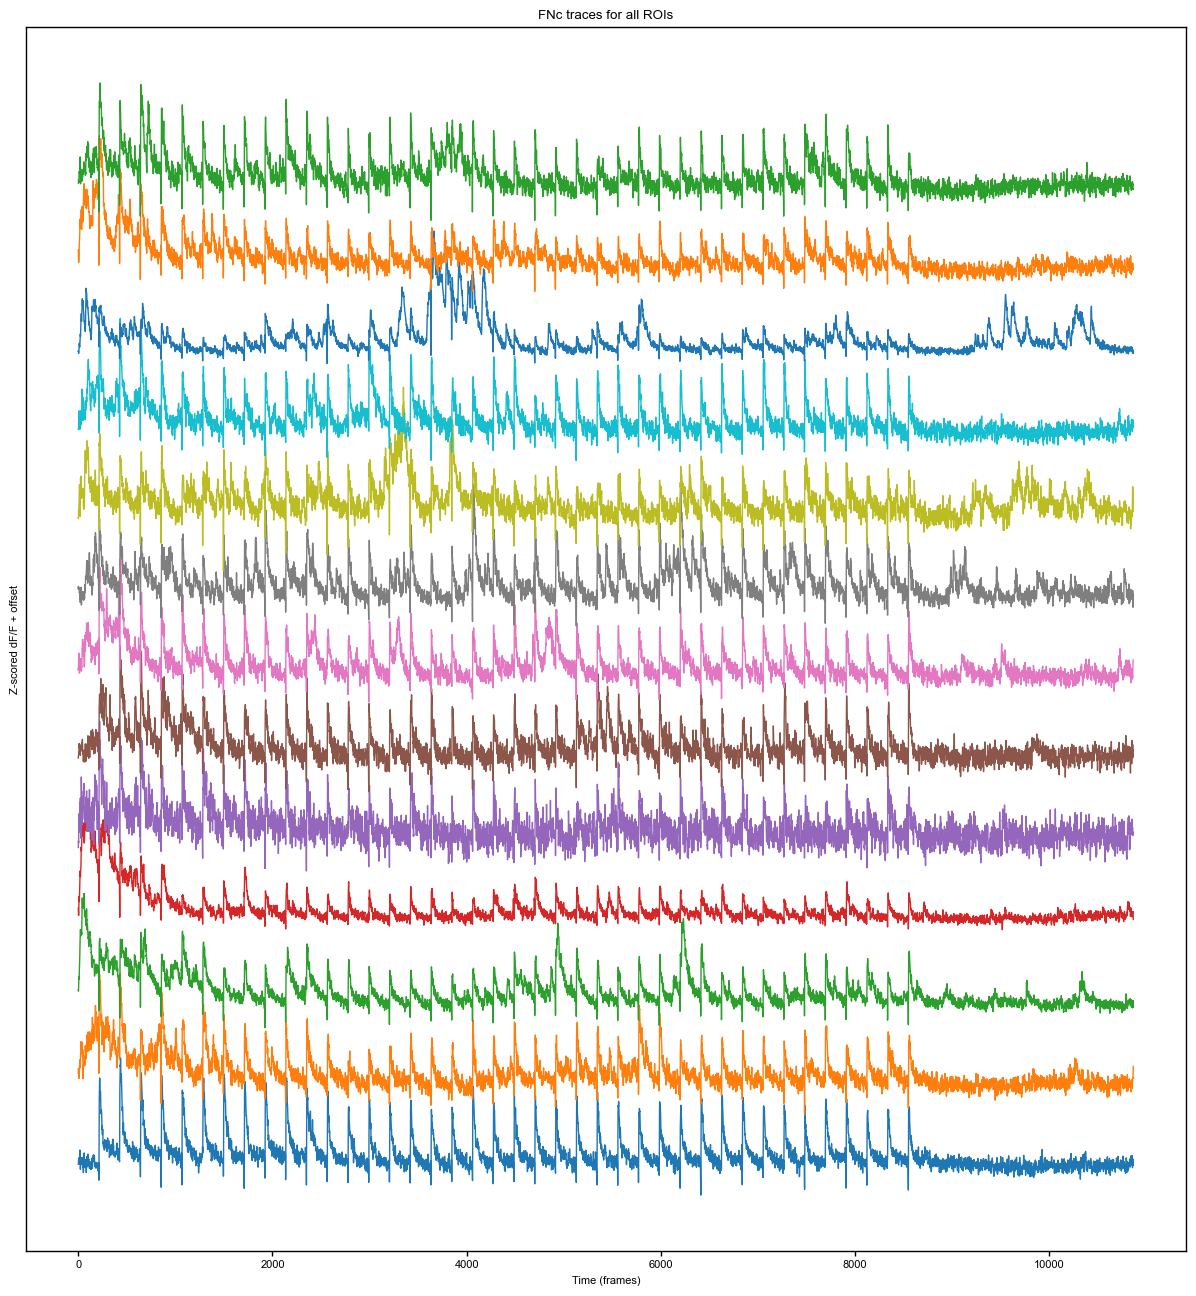

In [20]:

num_rois, num_timepoints = arr.shape

plt.figure(figsize=(12, num_rois * 1))


offset = 5  

for i in range(num_rois):
    
    plt.plot(arr[i] + i * offset, label=f'ROI {i+1}')

plt.xlabel('Time (frames)')
plt.ylabel('Z-scored dF/F + offset')
plt.title('FNc traces for all ROIs')
plt.yticks([]) 
plt.tight_layout()
plt.show()


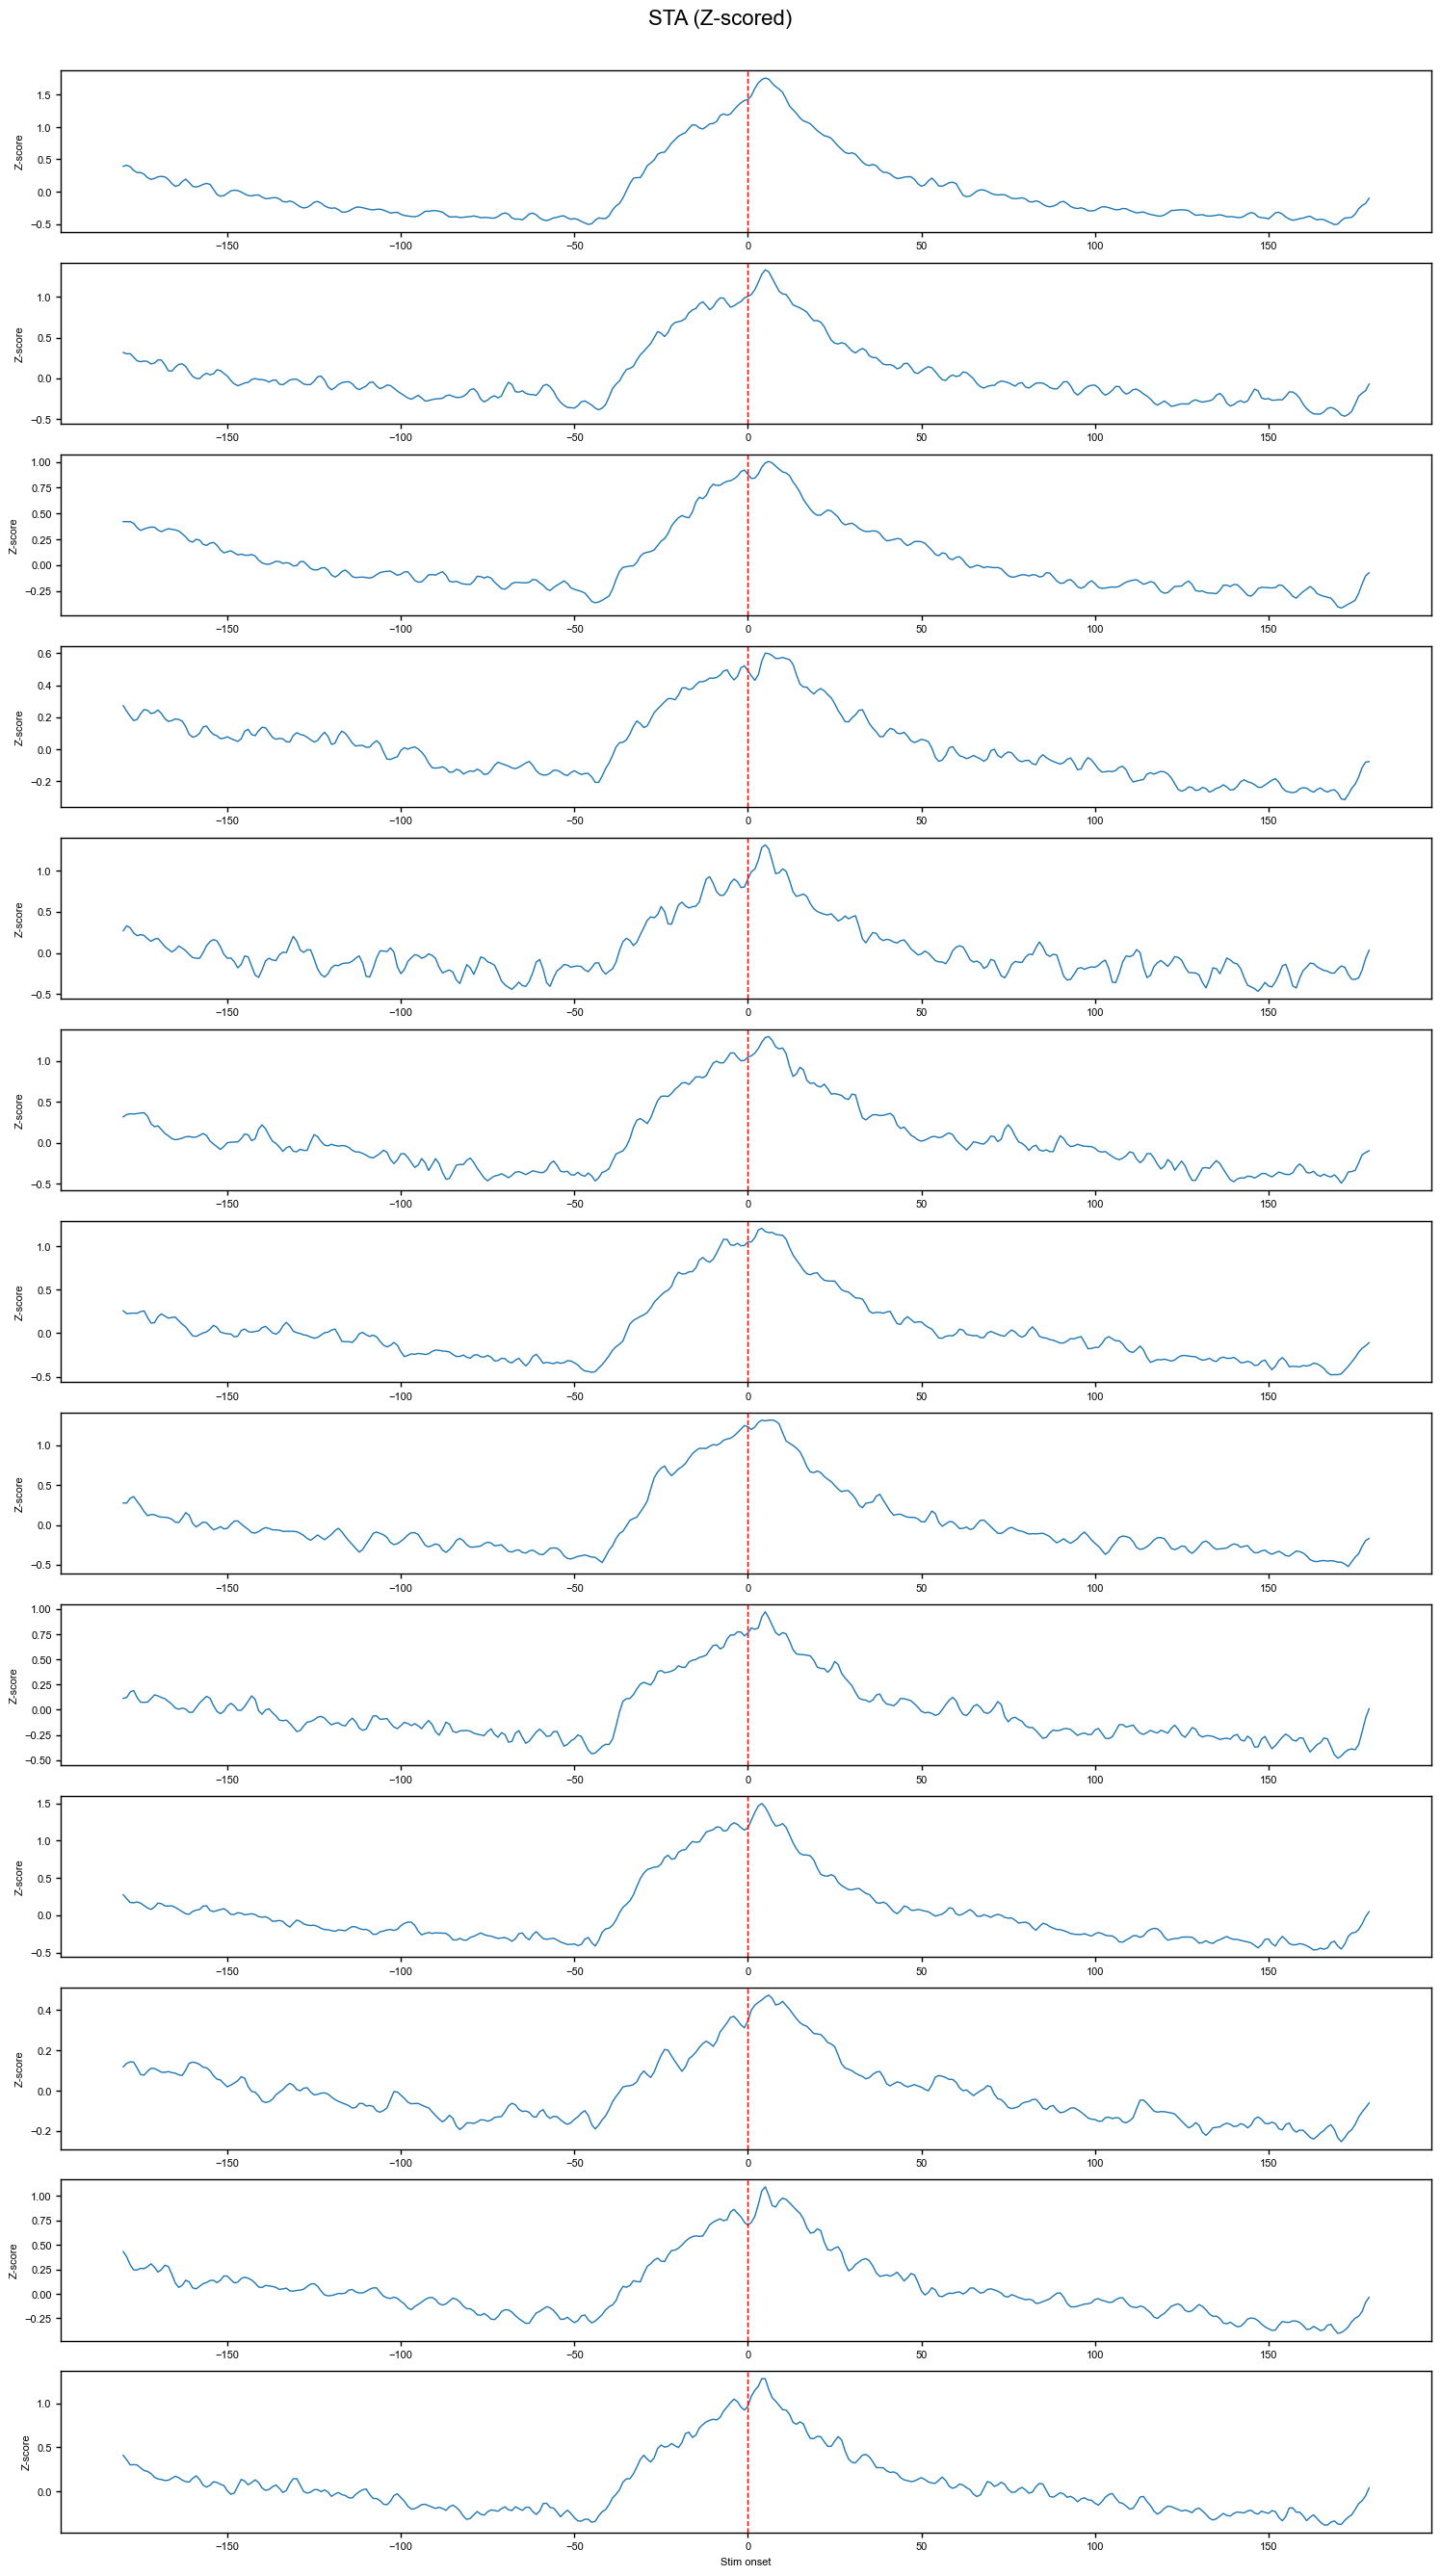

In [21]:
# STA approximate stim triggers
pre_frames = 180   
post_frames = 180  
win = pre_frames + post_frames  
n_rois = arr.shape[0]


trials = []

for trig in trigs:
    if trig - pre_frames >= 0 and trig + post_frames < arr.shape[1]:
        trial_window = arr[:, trig - pre_frames : trig + post_frames]
        trials.append(trial_window)

trials = np.stack(trials, axis=2)  


sta = np.mean(trials, axis=2)  


time_axis = np.arange(-pre_frames, post_frames)

plt.figure(figsize=(15, n_rois * 2))
for i in range(n_rois):
    plt.subplot(n_rois, 1, i + 1)
    plt.plot(time_axis, sta[i], label=f'ROI {i}')
    plt.axvline(0, color='red', linestyle='--', label='Stim Onset')
    plt.ylabel('Z-score')
    # plt.legend()
    plt.tight_layout()

plt.xlabel('Stim onset')
plt.suptitle('STA (Z-scored)', y=1.02, fontsize=16)
plt.show()
